<a href="https://colab.research.google.com/github/vvcastro/api-FaunaVision/blob/master/graph-neural-networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCNN - Cortical Thickness

In this notebook I will explore the performance of different layers when trying to fit our training set.

### 0. Install Dependicies:

We work with ```PyTorch Geometric``` and ```Meshio``` libraries...

In [ ]:
%%capture

# install torch geometric packages
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric

# ignite for metrics and evaluation
!pip install pytorch-lightning

# install meshio
!pip install meshio

The following code is needed to show error messages when using GPU acceleration with ```CUDA```:

In [ ]:
import os

# for error messages when using gpu
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Mount ```Google Drive``` to store models:

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# research folder
import os
HOME_FOLDER = os.path.join('/', 'content', 'drive', 'MyDrive', 'Investigaciones', 'research - Cortical Thickness')

Mounted at /content/drive


## 1. Load Dataset:

The dataset is loaded from a ```.zip``` file stored in Dropbox. It contains a ```.vtu``` file with the *t_norm* and *t_final* attribute on each node, and a ```.obj``` file that contains the general structure of each mesh.

In [ ]:
%%capture

# remove simulations
!rm -r simulations/

# donwload from dropbox
!wget 'https://www.dropbox.com/s/x0ck8zymwserudj/simulations.zip'
!unzip 'simulations.zip' -d simulations/

# remove unused files
!rm -r __MACOSX
!rm simulations.zip

### 1.1 Get filenames:

First we sort the simulations by the experiment, each datapoint (_experiment_) change the values for the **curvature sensitive parameter** and the **cortical growth paramter**.

In [ ]:
import os

# all available files
train_filenames = [f for f in os.listdir('simulations') if (('.vtu' in f) or ('.obj' in f))]
test_filenames = [f for f in os.listdir(os.path.join('simulations', 'testing')) if (('.vtu' in f) or ('.obj' in f))]

# split into experiments
train_experiments = {}
for filename in train_filenames:
    if (filename[:-4] not in train_experiments): train_experiments[filename[:-4]] = []
    train_experiments[filename[:-4]].append(filename)
    train_experiments[filename[:-4]].sort()

# test experiments
test_experiments = {}
for filename in test_filenames:
    if (filename[:-4] not in test_experiments): test_experiments[filename[:-4]] = []
    test_experiments[filename[:-4]].append(filename)
    test_experiments[filename[:-4]].sort()

# print info
print(f'Training: {len(train_experiments)} experiments found!')
print(f'Testing: {len(test_experiments)} experiments found!')

Training: 25 experiments found!
Testing: 4 experiments found!


### 1.2 Dataset Class:

Load meshes using ```torch_geometric``` and 
```meshio``` inside a DatasetClass:

1. A preprocessing of the mesh in needed, we'll have to transform from a _mesh_ structure to _graph_. For this we use the ```torch_geometric``` library.

2. We want to use the ***t_final* value** and the **node position** (```x attribute```) as the node features for the net to train. In other words, we want:
$$T_{norm} = NN(X, T_{final})$$
where $T_{norm}$ is the normalized cortical thickness on each node (```y attribute```).

3. Train set and validation set splits, note that testing data is a different set (a subfolder inside ```simulations/```)

4. Normalize features using training set attributes.

In [ ]:
from sklearn.model_selection import train_test_split
import torch_geometric as geotorch
import numpy as np
import meshio
import torch

class SimulationDataset:

    # transform from mesh to graphs
    transformer = geotorch.transforms.FaceToEdge(True)

    def __init__(self, train_experiments, test_experiments, data_dir='simulations'):

        # previous data dict
        self.train_experiments = train_experiments
        self.test_experiments  = test_experiments
        self.data_dir = data_dir

        # future structures
        self.train_meshes = {}       # dict with shape {"filename": [meshio_object, mesh]}

        # data splits related
        self.train_labels, self.train_data = [], []             # training filenames, meshes
        self.validation_labels, self.validation_data = [], []   # validation filenames, meshes

        # to be implemented
        self.test_labels, self.test_data = [], []
        self.test_meshes = {}           # dict with shape {"filename":  [meshio_obj, mesh]}

        # normalization: training values
        self.outputs_mean, self.outputs_std = 0, 0

    def load_train_experiments(self):
        """ Load each mesh files (.obj) and (.vtu). """
        for experiment in self.train_experiments:
                
            # filepath
            path = os.path.join(self.data_dir, experiment)

            # load files
            mesh_structure = geotorch.io.read_obj(path + '.obj')
            mesh_nodes = meshio.read(path + '.vtu')

            # get node features and final value (position + t_final)
            input_vector = np.concatenate((mesh_nodes.point_data['t_final'].reshape(-1, 1), mesh_nodes.points), axis=1)
            output_vector = mesh_nodes.point_data['t_norm'].reshape(-1, 1)

            # put features into mesh_structure (needs to be a geotorch Data class)
            mesh_structure.x = torch.tensor(input_vector)
            mesh_structure.y = torch.tensor(output_vector)

            # save meshes
            self.train_meshes[experiment] = [mesh_nodes, self.transformer(mesh_structure).to('cuda')]

        return f'Done: {len(self.train_meshes)} meshes loaded!'
    
    def load_testing_set(self):
        """ Load each mesh files (.obj) and (.vtu). """
        for experiment in self.test_experiments:
                
            # filepath
            path = os.path.join(self.data_dir, 'testing', experiment)

            # load files
            mesh_structure = geotorch.io.read_obj(path + '.obj')
            mesh_nodes = meshio.read(path + '.vtu')

            # get node features and final value (position + t_final)
            input_vector = np.concatenate((mesh_nodes.point_data['t_final'].reshape(-1, 1), mesh_nodes.points), axis=1)
            output_vector = mesh_nodes.point_data['t_norm'].reshape(-1, 1)

            # put features into mesh_structure (needs to be a geotorch Data class)
            mesh_structure.x = torch.tensor(input_vector)
            mesh_structure.y = torch.tensor(output_vector)

            # save meshes
            self.test_meshes[experiment] = [mesh_nodes, self.transformer(mesh_structure).to('cuda')]
        
        # split into labels and data
        for label, mesh in self.test_meshes.items():
            self.test_labels.append(label)
            self.test_data.append(mesh[1])

        return 'Done!'

    def train_validation_splits(self, train_size=0.8):
        """ Splits dataset into training and testing"""
        
        # get filenames and meshes object
        data_labels, data_meshes = [], []
        for label, meshes in self.train_meshes.items():
            data_labels.append(label)
            data_meshes.append(meshes[1])

        # split into training and testing
        train_X, valid_X, train_Y, valid_Y = train_test_split(data_meshes, data_labels, train_size=train_size)

        # store splits
        self.train_labels, self.train_data = train_Y, train_X
        self.validation_labels, self.validation_data = valid_Y, valid_X

        return 'Done!'
    
    def normalize_dataset(self):
        """ Normalize training, validation and testing sets according
            training values. """
        
        # get values from training
        input_features, output_values = [], []
        for mesh in self.train_data:
            input_features.append(mesh.x)
            output_values.append(mesh.y)

        # concatenate values
        input_features = torch.cat(input_features, axis=0)
        output_values = torch.cat(output_values, axis=0)

        # mean and std values (store values for output de-normalization)
        inputs_mean, inputs_std = torch.mean(input_features), torch.std(input_features)
        self.outputs_mean, self.outputs_std = torch.mean(output_values), torch.std(output_values)

        # normalize function
        def normalize_set(dataset):
            for mesh in dataset:
                mesh.x = ((mesh.x - inputs_mean) / inputs_std).double()
                mesh.y = ((mesh.y - self.outputs_mean) / self.outputs_std).double()
        
        # normalize training, validation and test
        normalize_set(self.train_data)
        normalize_set(self.validation_data)
        normalize_set(self.test_data)

        return 'Done!'


### 1.3 Load Dataset (using ```SimulationDataset```):


In [ ]:
# define class
dataset = SimulationDataset(train_experiments, test_experiments, data_dir='simulations')

# load experiments
dataset.load_train_experiments()
dataset.load_testing_set()

# data splits and normalize
dataset.train_validation_splits(train_size=0.75)
dataset.normalize_dataset()

'Done!'

## 2. Metrics and Visualization:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import meshio
import shutil
import os

def filed_predicted_meshes(dataset, model):
    """ Predicted t_norm over meshes in testing set of 'dataset' and
        return a .vtu file with the predicted values and error. """
    
    # creates directory files
    os.makedirs(f'{model.name}-outputs', exist_ok=True)

    # for each mesh predict t_norm
    for label, mesh in zip(dataset.test_labels, dataset.test_data):

        # get predicted, ground truth and error
        t_norm = (model(mesh).detach() * dataset.outputs_std + dataset.outputs_mean).cpu()
        g_truth = (mesh.y * dataset.outputs_std + dataset.outputs_mean).cpu()
        error = torch.abs(g_truth - t_norm).cpu()
        
        # gets meshio object for the mesh
        meshio_obj = dataset.test_meshes[label][0]

        # create and write mesh estructure
        final_mesh = meshio.Mesh(
            points=meshio_obj.points,
            cells=meshio_obj.cells,
            point_data = {'predicted': t_norm.numpy(), 'g_truth': g_truth.numpy(), 'error': error.numpy()},
        ).write(os.path.join(f'{model.name}-outputs', f"{label}.vtu"), file_format="vtu")

    # zip output folder
    shutil.make_archive(f'{model.name}-outputs', 'zip', f'{model.name}-outputs/')    
    return True

def plot_predicted_error(dataset, model):
    """ Histogram plot for the predicted error. """
    
    # get predictions for each test mesh
    predictions, truths = [], []
    for mesh in dataset.test_data:
        predictions.append((model(mesh).detach() * dataset.outputs_std + dataset.outputs_mean).cpu().numpy())
        truths.append((mesh.y * dataset.outputs_std + dataset.outputs_mean).cpu().numpy())
    predictions = np.concatenate(predictions)
    ground_truth = np.concatenate(truths)

    # set title and axis
    fig = plt.figure(figsize=(12, 8))
    plt.title(f'Errors with model: {model.name}')
    plt.xlabel('Error'), plt.ylabel('Count')

    # calculate error and plot
    error = predictions - ground_truth
    plt.hist(error)
    plt.show()

    return 'Done!'

def plot_model_metrics(model):
    """ Plot training and validation loss. """

    # plot loss graphs
    fig, ax = plt.subplots(1, 3, figsize=(30, 8))
    
    # labels
    ax[0].set_title(f'{model.name} - Mean Squared Error')
    ax[1].set_title(f'{model.name} - Mean Absolute Error')
    ax[2].set_title(f'{model.name} - Mean R Squared')

    # axis    
    ax[0].set_xlabel('Epoch'), ax[1].set_xlabel('Epoch'), ax[2].set_xlabel('Epoch')
    ax[0].set_ylabel('log Mean Squared Error'), ax[1].set_ylabel('log Mean Absolute Error'), ax[2].set_ylabel('R2 Value')

    # log scale
    ax[0].set_yscale('log'), ax[1].set_yscale('log')

    # plt on each ax
    for i, metric in enumerate(['MSE', 'MAE', 'R2']):
        
        # metric values
        train_values = [train_metric[i] for train_metric in model.training_metrics]
        valid_values = [valid_metric[i] for valid_metric in model.validation_metrics]

        # plt
        ax[i].plot(model.epochs, train_values, 'r-', label=f'Training {metric}')
        ax[i].plot(model.epochs, valid_values, 'b--', label=f'Validation {metric}')

        # set legend
        ax[i].legend(loc='best')

    plt.show()
    return 'Done!'

## 3. Base Model class:
Train pipeline definition:

In [ ]:
from pytorch_lightning.metrics import R2Score, MeanAbsoluteError, MeanSquaredError
from math import log2
import torch
import os

class GraphNeuralNetwork(torch.nn.Module):

    def __init__(self, num_layers, hidden_channels, device='cuda'):
        super(GraphNeuralNetwork, self).__init__()

        # set model name and device
        self.name = ''
        self.device = device

        # parameters
        self.num_layers = min(num_layers, log2(hidden_channels))
        self.hidden_channels = hidden_channels

        # layers
        self.layers = torch.nn.ModuleList()
        self.output_layer = None

        # validation-training metrics
        self.training_metrics = []
        self.validation_metrics = []
        self.epochs = []

        # move to device
        self.to(device)

    def forward(self, graph):
        """ Simple forward through layers"""
        
        # extract attributes and edge_inde
        x, edge_index = graph.x, graph.edge_index

        # forward in each layer
        for layer in self.layers:
            x = layer(x, edge_index)
        
        # forward output layer
        return self.output_layer(x, edge_index)

    def train_step(self, train_data, optimizer, criterion):
        """ Run an optimization step in the model weights. """

        # loss function over step
        step_loss = []

        # use batch training
        for batch in train_data:

            # gradiento to zero
            optimizer.zero_grad()

            # calculate loss
            batch_loss = criterion(self(batch), batch.y)
            batch_loss.backward()

            # optimization step
            optimizer.step()

            # store loss value
            step_loss.append(batch_loss.item())
        
        # return loss value
        return torch.mean(torch.tensor(step_loss))

    
    def evaluate_model(self, evaluation_data):
        """ 
        Evaluate model in the given dataset...
        metrics: R2 Score, MSE, MAE...
        """

        # metric definition
        mse = MeanSquaredError().to(self.device)
        mae = MeanAbsoluteError().to(self.device)
        r2 = R2Score().to(self.device)

        # store metrics
        mse_scores, mae_scores, r2_scores = [], [], []
        for batch in evaluation_data:
            
            # get prediction
            y_pred = self(batch)

            # calculate scores
            mse_scores.append(mse(y_pred, batch.y))
            mae_scores.append(mae(y_pred, batch.y))
            r2_scores.append(r2(y_pred, batch.y))
        
        # pass scores to tensors
        mse_score = torch.mean(torch.tensor(mse_scores))
        mae_score = torch.mean(torch.tensor(mae_scores))
        r2_score = torch.mean(torch.tensor(r2_scores))

        # return mean of each score
        return mse_score, mae_score, r2_score

    def save_model(self, optimizer, epoch):
        """ Store model state in $HOME_FOLDER directory... """

        # make dir
        os.makedirs(os.path.join(HOME_FOLDER, self.name), exist_ok=True)

        # save model
        torch.save({
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'metrics': {'training-metrics': self.training_metrics,
                        'validation-metrics': self.validation_metrics,
                        'epochs': self.epochs}, 
        }, os.path.join(HOME_FOLDER, self.name, f'last_snapshot.pkl'))
        return 'Done!'

    def load_from_snapshot(self, optimizer, path=None):
        """ Load a model from its last .pkl file... """
        
        print("LOADING MODEL...")

        # search for last file in model directory
        pkl_file = ''
        for root, _, files in os.walk(os.path.join(HOME_FOLDER, self.name)):
            for f in files:
                if ('.pkl' in f):
                    pkl_file = f_path = os.path.join(root, f)
        if (path is not None): pkl_file = path

        # print information
        if (pkl_file == ''): 
            print("  - No previous file...")
            return 0

        else: print(f" - Loading from {pkl_file}")

        # load last pkl file
        snapshot = torch.load(pkl_file)
        last_epoch = 0
        try:

            # load states
            self.load_state_dict(snapshot['model_state_dict'])
            optimizer.load_state_dict(snapshot['optimizer_state_dict'])
                    
            # load last metrics
            self.training_metrics = snapshot['metrics']['training-metrics']
            self.validation_metrics = snapshot['metrics']['validation-metrics']
            self.epochs = snapshot['metrics']['epochs']
            last_epoch = snapshot['epoch']

        except RuntimeError:
            print("  - Architecture changes! Aborting ... ")
            os.remove(pkl_file)
        
        # return last epoch of training
        return last_epoch


## 4. Graph Neural Networks Models:

In this section we will explore different architectures based on _Graph Convolutional Networks_:

### 4.1 Vanilla GCNN Model (The Simplest Model):

#### Model definition:

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class VanillaLayer(torch.nn.Module):
    activation_functions = {
        'sigmoid': torch.nn.Sigmoid(),
        'leaky-relu': torch.nn.LeakyReLU(negative_slope=0.25 ),
        'tanh': torch.nn.Tanh(),
        'none': torch.nn.Identity()
    }

    def __init__(self, input_channels, out_channels, act):
        super(VanillaLayer, self).__init__()

        # pipeline
        self.conv = GCNConv(input_channels, out_channels, improved=True)
        self.activation = self.activation_functions[act]
        self.batchnorm = torch.nn.BatchNorm1d(out_channels, momentum=0.05, affine=True)
    
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        x = self.batchnorm(x)
        return self.activation(x)

class VanillaConvolution(GraphNeuralNetwork):
    def __init__(self, num_layers, hidden_channels):
        super(VanillaConvolution, self).__init__(num_layers, hidden_channels, device='cuda')

        # set model name
        self.name = f'VanillaGCNN-L{self.num_layers}-CH{self.hidden_channels}'

        # add first layers
        self.layers.append(VanillaLayer(4, self.hidden_channels, act='tanh').to(self.device))

        # hidden_layers - 1
        for n_layer in range(self.num_layers - 1):
            this_layer = VanillaLayer(self.hidden_channels // 2**n_layer, self.hidden_channels // 2**(n_layer + 1), 'leaky-relu')
            self.layers.append(this_layer.to(self.device))

        # output layer
        self.output_layer = VanillaLayer(self.hidden_channels // 2**(n_layer + 1), 1, act='none').to(self.device)


#### Instanciate/Load model and training:

In [ ]:
########################
###### PARAMETERS ######
########################
# optimizer and training
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 3e-2
BATCH_SIZE = 8

# loss functions to use
criterion = torch.nn.MSELoss()

# instantiate model and optimizer
vanilla_model = VanillaConvolution(num_layers=5, hidden_channels=256).double()
vanilla_optimizer = torch.optim.AdamW(vanilla_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# load if a snapshot exists
print("#" * 20)
last_epoch = vanilla_model.load_from_snapshot(vanilla_optimizer)

# training and validationdata (use mini-batch)
train_data = geotorch.data.DataLoader(dataset.train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data = geotorch.data.DataLoader(dataset.validation_data, batch_size=3)

# print model
print("#" * 20)
# vanilla_model

####################
LOADING MODEL...
 - Loading from /content/drive/MyDrive/Investigaciones/research - Cortical Thickness/VanillaGCNN-L5-CH256/last_snapshot.pkl
####################


In [ ]:
from tqdm.notebook import tqdm

########################
###### TRAIN-LOOP ######
########################

# training snapshots
LOOP_PARAMS = {'epochs': 15000, 'eval_epoch': 250, 'snapshot_epoch': 2500}

# train
model = vanilla_model
optimizer = vanilla_optimizer
model.train()

# train for the given number of epochs
if (last_epoch != 0): 
    print(f"Resuming from epoch {last_epoch}")
    last_epoch += 1
for epoch in tqdm(range(last_epoch, last_epoch + LOOP_PARAMS['epochs'] + 1), desc='Training'):

    # minibatch training
    model.train_step(train_data, optimizer, criterion)

    # evaluation epoch
    if (epoch % LOOP_PARAMS['eval_epoch'] == 0):

        # put model on evaluation
        model.eval()

        model.training_metrics.append(model.evaluate_model(train_data))
        model.validation_metrics.append(model.evaluate_model(valid_data))
        model.epochs.append(epoch)

        # model back to training
        model.train()
    
    # save model
    if (epoch % LOOP_PARAMS['snapshot_epoch'] == 0):
        model.save_model(optimizer, epoch)

#### Metrics and Error Visualization:

Training and Validation metrics:

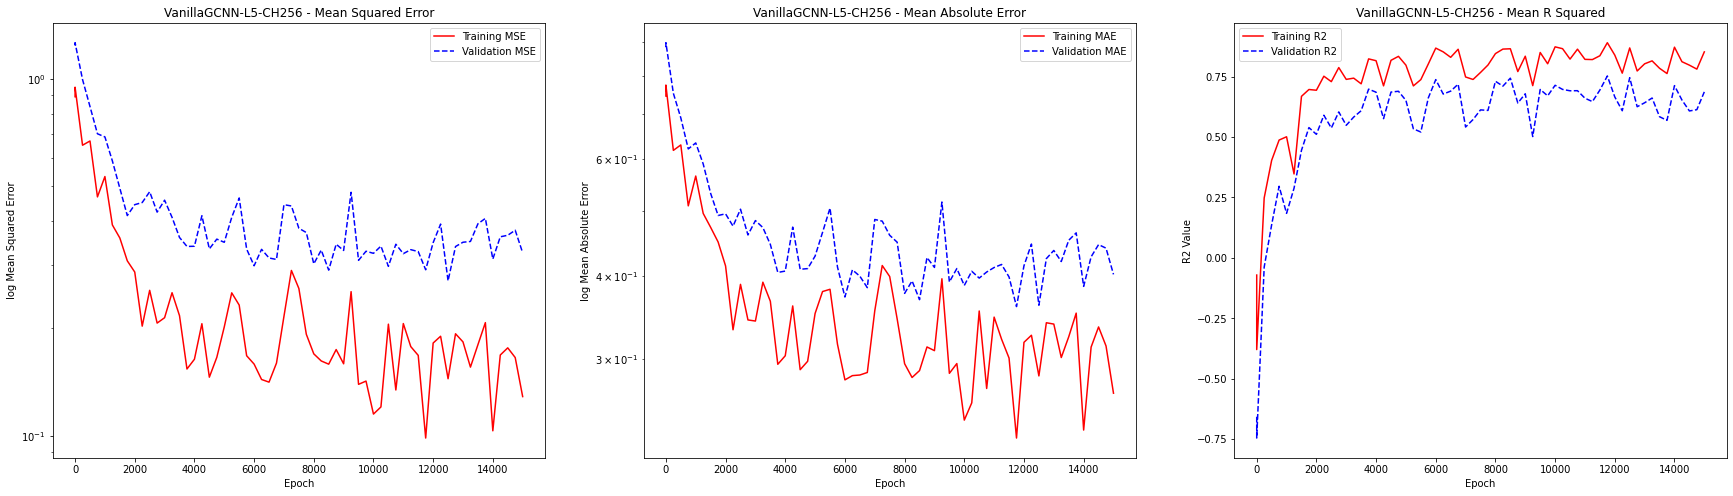

'Done!'

In [ ]:
plot_model_metrics(vanilla_model)

Calculate error distribution:

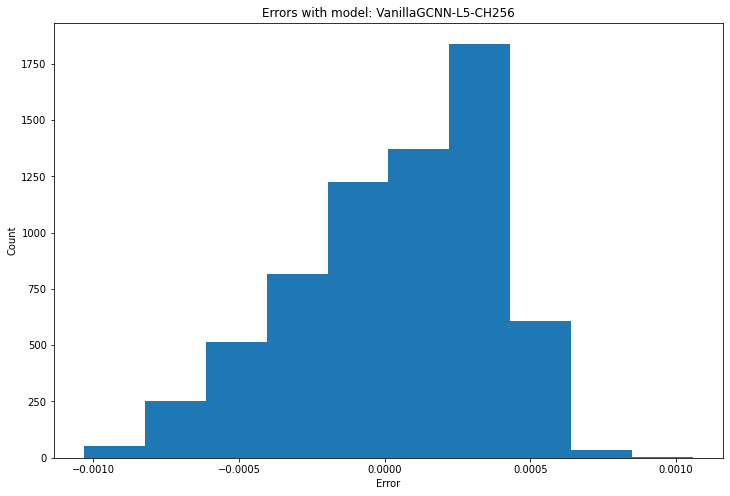

'Done!'

In [ ]:
plot_predicted_error(dataset, vanilla_model)

Get test meshes ```.vtu``` files:

In [ ]:
# zip files
!rm VanillaGCNN-output.zip
filed_predicted_meshes(dataset, vanilla_model)

# remove mesh folder
!rm -r VanillaGCNN-outputs/

rm: cannot remove 'VanillaGCNN-output.zip': No such file or directory


### 4.3 Deeper Convolution:

#### Model Definition:

In [ ]:
from torch_geometric.nn import GENConv, DeepGCNLayer, FeaStConv
import torch

class DeepLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, act_fun, block='res+'):
        super(DeepLayer, self).__init__()

        # define conv and normalization
        conv = GENConv(in_channels, in_channels, num_layers=3)
        norm = torch.nn.BatchNorm1d(in_channels, momentum=0.08, affine=True)
        self.layer = DeepGCNLayer(conv, norm, act_fun, block, dropout=0.05, ckpt_grad=True)
        
        # define FC layer to out_channels
        self.encoder = torch.nn.Linear(in_channels, out_channels)
        self.out_channels = out_channels

    def forward(self, x, edge_index):
        x = self.layer(x, edge_index)
        return self.encoder(x)

class DeeperGCN(GraphNeuralNetwork):
    def __init__(self, num_layers, hidden_channels):
        super(DeeperGCN, self).__init__(num_layers, hidden_channels, device='cuda')

        # store attributes
        self.name = f'DeeperGCN-L{self.num_layers}-CH{self.hidden_channels}'

        # node encoder to hidden_channels
        self.in_encoder = torch.nn.Linear(4, self.hidden_channels).to(self.device)

        # initiate layers list
        activation_functs = [torch.nn.LeakyReLU(negative_slope=0.25)] * (self.num_layers - 2) + [torch.nn.Tanh()] * 2
        for n_layer, act_fun in zip(range(self.num_layers), activation_functs):
            
            # add deep layer
            self.layers.append(DeepLayer(self.hidden_channels // 2**n_layer,
                                         self.hidden_channels // 2**(n_layer + 1),
                                         act_fun, block='res+').to(self.device))

        # last layer
        self.output_layer = FeaStConv(self.layers[-1].out_channels, 1, heads=3)

    def forward(self, graph):
        """ Simple forward through layers"""
        
        # extract attributes and edge_inde
        x, edge_index = self.in_encoder(graph.x), graph.edge_index

        # forward in each layer
        for layer in self.layers:
            x = layer(x, edge_index)
        
        # forward output layer
        return self.output_layer(x, edge_index)

#### Intanciate/Load Model and Train:

In [ ]:
########################
###### PARAMETERS ######
########################
# optimizer and training
LEARNING_RATE = 3e-3
WEIGHT_DECAY = 3e-2
BATCH_SIZE = 8

# loss functions to use
criterion = torch.nn.MSELoss()

# instantiate model and optimizer
deeper_model = DeeperGCN(num_layers=5, hidden_channels=256).double().to('cuda')
deeper_optimizer = torch.optim.AdamW(deeper_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# load if a snapshot exists
print("#" * 20)
last_epoch = deeper_model.load_from_snapshot(deeper_optimizer)

# training and validationdata (use mini-batch)
train_data = geotorch.data.DataLoader(dataset.train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_data = geotorch.data.DataLoader(dataset.validation_data, batch_size=3)

# print model
print("#" * 20)
deeper_model

####################
LOADING MODEL...
 - Loading from /content/drive/MyDrive/Investigaciones/research - Cortical Thickness/DeeperGCN-L5-CH256/last_snapshot.pkl
####################


DeeperGCN(
  (layers): ModuleList(
    (0): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=256, out_features=128, bias=True)
    )
    (1): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=128, out_features=64, bias=True)
    )
    (2): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=64, out_features=32, bias=True)
    )
    (3): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=32, out_features=16, bias=True)
    )
    (4): DeepLayer(
      (layer): DeepGCNLayer(block=res+)
      (encoder): Linear(in_features=16, out_features=8, bias=True)
    )
  )
  (in_encoder): Linear(in_features=4, out_features=256, bias=True)
  (output_layer): FeaStConv(8, 1, heads=3)
)

In [ ]:
from tqdm.notebook import tqdm

########################
###### TRAIN-LOOP ######
########################

# training snapshots
LOOP_PARAMS = {'epochs': 5000, 'eval_epoch': 250, 'snapshot_epoch': 2500}

# train
model = deeper_model
optimizer = deeper_optimizer
model.train()

# train for the given number of epochs
if (last_epoch != 0): 
    print(f"Resuming from epoch {last_epoch}")
    last_epoch += 1
for epoch in tqdm(range(last_epoch, last_epoch + LOOP_PARAMS['epochs'] + 1), desc='Training'):

    # minibatch training
    model.train_step(train_data, optimizer, criterion)

    # evaluation epoch
    if (epoch % LOOP_PARAMS['eval_epoch'] == 0):

        # put model on evaluation
        model.eval()

        model.training_metrics.append(model.evaluate_model(train_data))
        model.validation_metrics.append(model.evaluate_model(valid_data))
        model.epochs.append(epoch)

        # model back to training
        model.train()
    
    # save model
    if (epoch % LOOP_PARAMS['snapshot_epoch'] == 0):
        model.save_model(optimizer, epoch)

Resuming from epoch 27500


#### Metrics and Error Visualization:

Training and Validation Metrics:

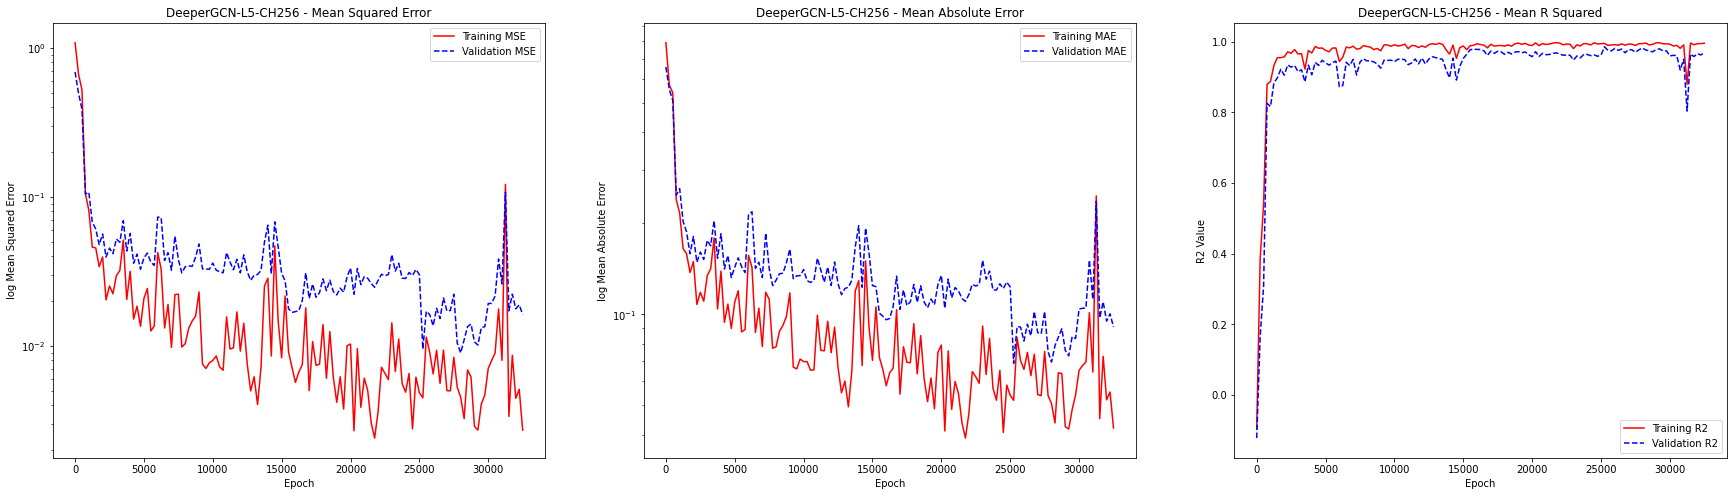

'Done!'

In [ ]:
plot_model_metrics(deeper_model)

Error in Testing set:

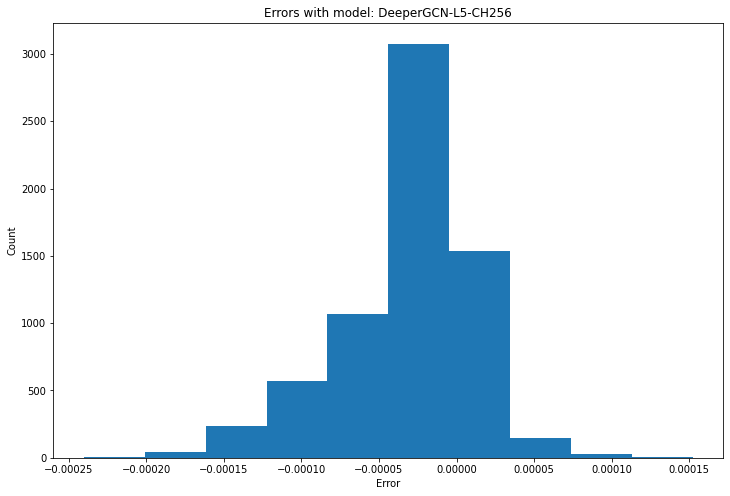

'Done!'

In [ ]:
plot_predicted_error(dataset, deeper_model)

In [ ]:
# zip files
# !rm DeeperGCN-output.zip
filed_predicted_meshes(dataset, deeper_model)

# remove mesh folder
# !rm -r DeeperGCN-outputs/

True